### Final result( named as 'final_hourly' in this notebook) was saved as a new csv file 'hourly_result.csv'(Please refer to the end of the notebook for the visualization of the result) 

### Solutions summary:
1. Load data with pandas dataframe and visualize data
2. calculate ratio of each week's normalized value within each month in 'weekly_data.csv' and get the actual comparable based on monthly value in 'monthly_data.csv';
3. Likewise, calculate ratio of each hour's normalized value within each week in 'hourly_data.csv' and get the actual comparable based on weekly value in 'weekly_data.csv'; ---- This is the final result.

In [1]:
# import packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
hourly_raw = pd.read_csv('hourly_data.csv')
weekly_raw = pd.read_csv('weekly_data.csv')
monthly_raw = pd.read_csv('monthly_data.csv')

In [15]:
# visualize data
hourly_raw.head() # comparable within a week

,time_hour,value_hour,date
0,1483228800,30,2017-01-01 00:00:00
1,1483232400,34,2017-01-01 01:00:00
2,1483236000,33,2017-01-01 02:00:00
3,1483239600,43,2017-01-01 03:00:00
4,1483243200,32,2017-01-01 04:00:00


In [16]:
weekly_raw.head() #comparable within a month

,time_week,value_week,date
0,1483228800,100,2017-01-01
1,1483833600,84,2017-01-08
2,1484438400,63,2017-01-15
3,1485043200,56,2017-01-22
4,1485648000,60,2017-01-29


In [17]:
monthly_raw.head() # comparable monthly

,time_month,value_month,date
0,1483228800,6,2017-01-01
1,1485907200,6,2017-02-01
2,1488326400,7,2017-03-01
3,1491004800,6,2017-04-01
4,1493596800,15,2017-05-01


In [8]:
# check datatype of date column in monthly_raw, weekly_raw, hourly_raw
print(f"Monthly_raw 'date' column type is {type(monthly_raw.date[0])}")
print(f"Weekly_raw 'date' column type is {type(weekly_raw.date[0])}")
print(f"Hourly_raw 'date' column type is {type(hourly_raw.date[0])}")

Monthly_raw 'date' column type is <class 'str'>
Weekly_raw 'date' column type is <class 'str'>
Hourly_raw 'date' column type is <class 'str'>


In [12]:
# convert date column to datetime type
monthly_raw['date'] = pd.to_datetime(monthly_raw.date)
hourly_raw['date'] = pd.to_datetime(hourly_raw.date)
weekly_raw['date'] = pd.to_datetime(weekly_raw.date)

In [93]:
# check datatype of date column in monthly_raw, weekly_raw, hourly_raw
print(f"After conversion, Monthly_raw 'date' column type is {type(monthly_raw.date[0])}")
print(f"After conversion, Weekly_raw 'date' column type is {type(weekly_raw.date[0])}")
print(f"After conversion, Hourly_raw 'date' column type is {type(hourly_raw.date[0])}")

After conversion, Monthly_raw 'date' column type is <class 'pandas._libs.tslibs.timestamps.Timestamp'>
After conversion, Weekly_raw 'date' column type is <class 'pandas._libs.tslibs.timestamps.Timestamp'>
After conversion, Hourly_raw 'date' column type is <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [18]:
# check missing values
hourly_raw.isnull().sum()

time_hour     0
value_hour    0
date          0
dtype: int64

In [19]:
weekly_raw.isnull().sum()

time_week     0
value_week    0
date          0
dtype: int64

In [20]:
monthly_raw.isnull().sum()

time_month     0
value_month    0
date           0
dtype: int64

#### There is no missing values

## Step 1: Since in monthly_raw dataframe all values are comparable, calculate comparable weekly values based on monthly_raw and weekly_raw


In [46]:
# extract values and date from weekly_raw
weekly_values = weekly_raw.value_week
weekly_values.index = weekly_raw.date
weekly_values  = pd.DataFrame(weekly_values)

In [47]:
# get total normalized value of each month from weekly_raw 
weekly_total = weekly_values.resample('M').sum() 

In [48]:
weekly_total = pd.DataFrame(weekly_total).reset_index()
weekly_total.columns = ['weekly_date', 'value_sum_week'] # rename columns

In [49]:
weekly_total # Note: weekly_date is the last day of the month after resampling by month

,weekly_date,value_sum_week
0,2017-01-31,363
1,2017-02-28,282
2,2017-03-31,331
3,2017-04-30,372
4,2017-05-31,270
...,...,...
63,2022-04-30,98
64,2022-05-31,170
65,2022-06-30,269
66,2022-07-31,221


In [50]:
# join dataframe weekly_total and weekly_raw to get total normalized value of each month
weekly_df = pd.merge(weekly_raw.assign(grouper=weekly_raw['date'].dt.to_period('M')),
               weekly_total.assign(grouper=weekly_total['weekly_date'].dt.to_period('M')),
               how='left', on='grouper')

In [51]:
# get the value ratio of each week within each month
weekly_df['ratio_within_month'] = weekly_df['value_week'] / weekly_df['value_sum_week']

In [52]:
weekly_df = weekly_df.drop(['grouper'], axis = 1) # drop grouper

In [53]:
weekly_df.head()

,time_week,value_week,date,weekly_date,value_sum_week,ratio_within_month
0,1483228800,100,2017-01-01,2017-01-31,363,0.275482
1,1483833600,84,2017-01-08,2017-01-31,363,0.231405
2,1484438400,63,2017-01-15,2017-01-31,363,0.173554
3,1485043200,56,2017-01-22,2017-01-31,363,0.154270
4,1485648000,60,2017-01-29,2017-01-31,363,0.165289


In [54]:
# join monthly_raw with weekly_df based on year and month
weekly = pd.merge(weekly_df.assign(grouper=weekly_df['date'].dt.to_period('M')), 
                 monthly_raw.assign(grouper=monthly_raw['date'].dt.to_period('M')),
                 how ='left', on = 'grouper')

In [55]:
# get the real comparabel value for each week based on value_month and and ratio_within_month
weekly['value_week_comparable'] = weekly['ratio_within_month'] * weekly['value_month']

In [56]:
weekly.head()

,time_week,value_week,date_x,weekly_date,value_sum_week,ratio_within_month,grouper,time_month,value_month,date_y,value_week_comparable
0,1483228800,100,2017-01-01,2017-01-31,363,0.275482,2017-01,1483228800,6,2017-01-01,1.652893
1,1483833600,84,2017-01-08,2017-01-31,363,0.231405,2017-01,1483228800,6,2017-01-01,1.388430
2,1484438400,63,2017-01-15,2017-01-31,363,0.173554,2017-01,1483228800,6,2017-01-01,1.041322
3,1485043200,56,2017-01-22,2017-01-31,363,0.154270,2017-01,1483228800,6,2017-01-01,0.925620
4,1485648000,60,2017-01-29,2017-01-31,363,0.165289,2017-01,1483228800,6,2017-01-01,0.991736


## Step 2: hourly_raw : calculate value ration within each week using hourly_raw

In [58]:
# get the total value within each week
# Note: Here each week is start from Sunday but not Monday as default. 

# extract hourly_value and date from hourly_raw
hourly_value = hourly_raw.value_hour
hourly_value.index = hourly_raw.date

In [60]:
# get the total value within each week
hourly_total = pd.DataFrame(hourly_value.resample('7D').sum()).reset_index() 
hourly_total.columns = ['hourly_date', 'value_sum_hour'] # rename columnns

In [62]:
hourly_total.head() # hourly_date is the start date of that week

,hourly_date,value_sum_hour
0,2017-01-01,10453
1,2017-01-08,10566
2,2017-01-15,11078
3,2017-01-22,11067
4,2017-01-29,10234


In [63]:
# get the end_date of each week by shifting the hourly_date columns and the last missing value manually
hourly_total['end_hourly_date'] = hourly_total['hourly_date'].shift(periods = -1).fillna('2022-08-28')
hourly_total['end_hourly_date'] = pd.to_datetime(hourly_total['end_hourly_date'])

In [64]:
hourly_total.columns = ['start_hourly_date', 'value_sum_hour', 'end_hourly_date'] # rename columns

In [65]:
hourly_total.head()

,start_hourly_date,value_sum_hour,end_hourly_date
0,2017-01-01,10453,2017-01-08
1,2017-01-08,10566,2017-01-15
2,2017-01-15,11078,2017-01-22
3,2017-01-22,11067,2017-01-29
4,2017-01-29,10234,2017-02-05


In [66]:
# merge hourly_total with hourly_raw if hourly_date in between week's start and end date
hourly_merge = hourly_total.merge(hourly_raw, how='cross')

In [68]:
hourly_merge

,start_hourly_date,value_sum_hour,end_hourly_date,time_hour,value_hour,date
0,2017-01-01,10453,2017-01-08,1483228800,30,2017-01-01 00:00:00
1,2017-01-01,10453,2017-01-08,1483232400,34,2017-01-01 01:00:00
2,2017-01-01,10453,2017-01-08,1483236000,33,2017-01-01 02:00:00
3,2017-01-01,10453,2017-01-08,1483239600,43,2017-01-01 03:00:00
4,2017-01-01,10453,2017-01-08,1483243200,32,2017-01-01 04:00:00
...,...,...,...,...,...,...
14596595,2022-08-21,8605,2022-08-28,1661378400,90,2022-08-24 22:00:00
14596596,2022-08-21,8605,2022-08-28,1661382000,81,2022-08-24 23:00:00
14596597,2022-08-21,8605,2022-08-28,1661385600,77,2022-08-25 00:00:00
14596598,2022-08-21,8605,2022-08-28,1661389200,75,2022-08-25 01:00:00


In [70]:
# filter out records that don't meet the hourly_date is between start_hourly_date and end_hourly_date
hourly_merge = hourly_merge.query('date >= start_hourly_date and date < end_hourly_date')

In [73]:
hourly_merge.shape

(49480, 6)

In [74]:
# get the ratio of each hour within each week
hourly_merge['ratio_within_week'] = hourly_merge['value_hour']/hourly_merge['value_sum_hour']

## Step 3: join weekly with hourly_merge to get the final comparable hourly values

In [77]:
weekly.head()

,time_week,value_week,date_x,weekly_date,value_sum_week,ratio_within_month,grouper,time_month,value_month,date_y,value_week_comparable
0,1483228800,100,2017-01-01,2017-01-31,363,0.275482,2017-01,1483228800,6,2017-01-01,1.652893
1,1483833600,84,2017-01-08,2017-01-31,363,0.231405,2017-01,1483228800,6,2017-01-01,1.388430
2,1484438400,63,2017-01-15,2017-01-31,363,0.173554,2017-01,1483228800,6,2017-01-01,1.041322
3,1485043200,56,2017-01-22,2017-01-31,363,0.154270,2017-01,1483228800,6,2017-01-01,0.925620
4,1485648000,60,2017-01-29,2017-01-31,363,0.165289,2017-01,1483228800,6,2017-01-01,0.991736


In [78]:
# subset of weekly
weekly_new = weekly.loc[:, ['date_x', 'value_week_comparable']]

In [79]:
weekly_new.columns = ['start_hourly_date', 'value_week_comparable'] # rename columns

In [80]:
# merge hourly_merge and weekly 
hourly = pd.merge(hourly_merge, weekly_new, on = 'start_hourly_date')

In [82]:
hourly.head()

,start_hourly_date,value_sum_hour,end_hourly_date,time_hour,value_hour,date,ratio_within_week,value_week_comparable
0,2017-01-01,10453,2017-01-08,1483228800,30,2017-01-01 00:00:00,0.002870,1.652893
1,2017-01-01,10453,2017-01-08,1483232400,34,2017-01-01 01:00:00,0.003253,1.652893
2,2017-01-01,10453,2017-01-08,1483236000,33,2017-01-01 02:00:00,0.003157,1.652893
3,2017-01-01,10453,2017-01-08,1483239600,43,2017-01-01 03:00:00,0.004114,1.652893
4,2017-01-01,10453,2017-01-08,1483243200,32,2017-01-01 04:00:00,0.003061,1.652893


In [83]:
# get the comparable values in each hour
hourly['value_hourly_comparable'] = hourly['value_week_comparable'] * hourly['ratio_within_week']

In [98]:
# extract useful columns from hourly as final result
final_hourly = hourly.loc[:, ['date', 'value_hourly_comparable']]
final_hourly['time_hour'] = hourly_raw.time_hour

# Here is the final result

In [99]:
final_hourly ## this is the final result

,date,value_hourly_comparable,time_hour
0,2017-01-01 00:00:00,0.004744,1483228800
1,2017-01-01 01:00:00,0.005376,1483232400
2,2017-01-01 02:00:00,0.005218,1483236000
3,2017-01-01 03:00:00,0.006799,1483239600
4,2017-01-01 04:00:00,0.005060,1483243200
...,...,...,...
49475,2022-08-24 22:00:00,0.075326,1661378400
49476,2022-08-24 23:00:00,0.067794,1661382000
49477,2022-08-25 00:00:00,0.064446,1661385600
49478,2022-08-25 01:00:00,0.062772,1661389200


In [101]:
# save the dataframe as 'hourly_result.csv'
final_hourly.to_csv('hourly_result.csv')

### Summary: the 'value_hourly_comparable' and 'date' column in final_hourly dataframe are the comparable hourly values that are needed. 

<AxesSubplot:title={'center':'Hourly values'}, xlabel='date', ylabel='Hourly values'>

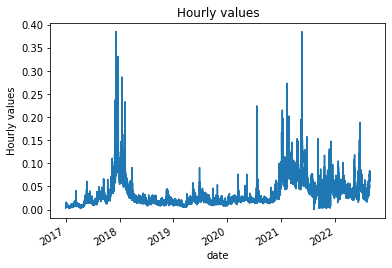

In [100]:
# visualize hourly values
hourly_value = final_hourly.value_hourly_comparable
hourly_value.index = final_hourly.date

hourly_value.plot(title='Hourly values', ylabel='Hourly values')